# Create a Hybrid Image

This notebook contains the code to generate a Hybrid Image from two images.
A general preprocessing of the images is expected to be done before running this code (See [Preprocessing](../README.md#Preprocessing)).

In [1]:
import os
import cv2
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# enum of filter modes
GAUSSIAN = "gaussian"
CUT = "cut"

## Configuration

The following variables can be configured to generate the hybrid image:

* `image_set_name`: The name of the image set to use. The images should be located in `image/<image_set_name>`.
* `size`: The size of the images to use (e. g. `128`, `256`, `512`, `1024`, `2048`). The images will be resized to this size.
* `filter_mode`: The mask to use for the low-pass and high-pass filters. Possible values are `gaussian` and `cut`.  
  <div style="display:flex;">
	<img src="assets/cut_mask.png" width="20%">
	<img style="padding-left: 8px;" src="assets/gaussian_mask.png" width="20%">
	</div>
	<br>
* `cutoff_frequencies`: The cutoff frequencies for the low-pass and high-pass filters.

In [2]:
image_set_name = "siggraph-dr-angry-mr-smile"

size = 128

filter_mode = GAUSSIAN

# Apply filters with different cutoff frequencies
cutoff_frequencies = [1, 5, 15, 20, 25, 50, 90]

## Filter Functions

In [3]:
def __distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def __gaussian_mask_lp(cf, img_shape):
    base = np.zeros(img_shape[:2])
    rows, cols = img_shape[:2]
    center = (rows / 2, cols / 2)
    for i in range(rows):
        for j in range(cols):
            base[i, j] = np.exp(-(__distance((i, j), center)) ** 2 / (2 * cf**2))
    return base

def __gaussian_mask_hp(cf, img_shape):
    return 1 - __gaussian_mask_lp(cf, img_shape)

def __cut_mask_lp(cf, img_shape):
    mask = np.zeros(img_shape[:2])
    rows, cols = img_shape[:2]
    center = (rows / 2, cols / 2)
    for i in range(rows):
        for j in range(cols):
            mask[i, j] = 1 if __distance((i, j), center) < cf else 0
    return mask

def __cut_mask_hp(cf, img_shape):
    return 1 - __cut_mask_lp(cf, img_shape)


def create_filtered_image(path, size, cf, use_high_pass=False, filter_mode=CUT):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (size, size))

    # Fourier Transform of the image
    ft = np.fft.fft2(image)

    # Apply Center Shifting (Shift the zero-frequency component to the center of the spectrum)
    ft = np.fft.fftshift(ft)

    # Apply Filter
    if filter_mode == GAUSSIAN:
        filter_mask = __gaussian_mask_hp(cf, image.shape) if use_high_pass else __gaussian_mask_lp(cf, image.shape)
    else:
        filter_mask = __cut_mask_hp(cf, image.shape) if use_high_pass else __cut_mask_lp(cf, image.shape)

    filtered_center = ft * filter_mask

    # Extract frequency component
    filtered_ft = np.fft.ifftshift(filtered_center)

    # Get image using Inverse FFT
    filtered_image = np.fft.ifft2(filtered_center)

    return np.abs(filter_mask), np.abs(ft), np.abs(filtered_center), np.abs(filtered_image)

In [4]:
def __get_path(image_set_name, image_name):
    return os.path.join("image", image_set_name, "aligned", image_name)


def apply_low_pass_filter(image_set_name, image_name="1.jpg", size=128, cf=25, filter_mode=CUT):
    path = __get_path(image_set_name, image_name)

    return create_filtered_image(path, size, cf, filter_mode=filter_mode)


def apply_high_pass_filter(image_set_name, image_name="2.jpg", size=128, cf=25, filter_mode=CUT):
    path = __get_path(image_set_name, image_name)

    return create_filtered_image(path, size, cf, use_high_pass=True, filter_mode=filter_mode)

In [5]:
def create_hybrid_image(image_lp, image_hp):
    return np.abs(image_hp) + np.abs(image_lp)

## Plotting the filtered / hybrid images

In [6]:
def plot_figure(plots: list, rows: int, columns: int, fig_width=15, fig_height=7):
    fig = plt.figure(figsize=(fig_width, fig_height))
    count = 1
    for image, title, is_fourier_domain in plots:
        fig.add_subplot(rows, columns, count)
        count += 1
        # 2048 is the maximum allowed value for a white pixel in a plot of the Fourier Transform. This value results in a good brightness of the plot.
        plt.imshow(
            image,
            "gray",
            vmin=0 if is_fourier_domain else None,
            vmax=2048 if is_fourier_domain else None,
        )
        plt.axis("off")
        plt.title(title)

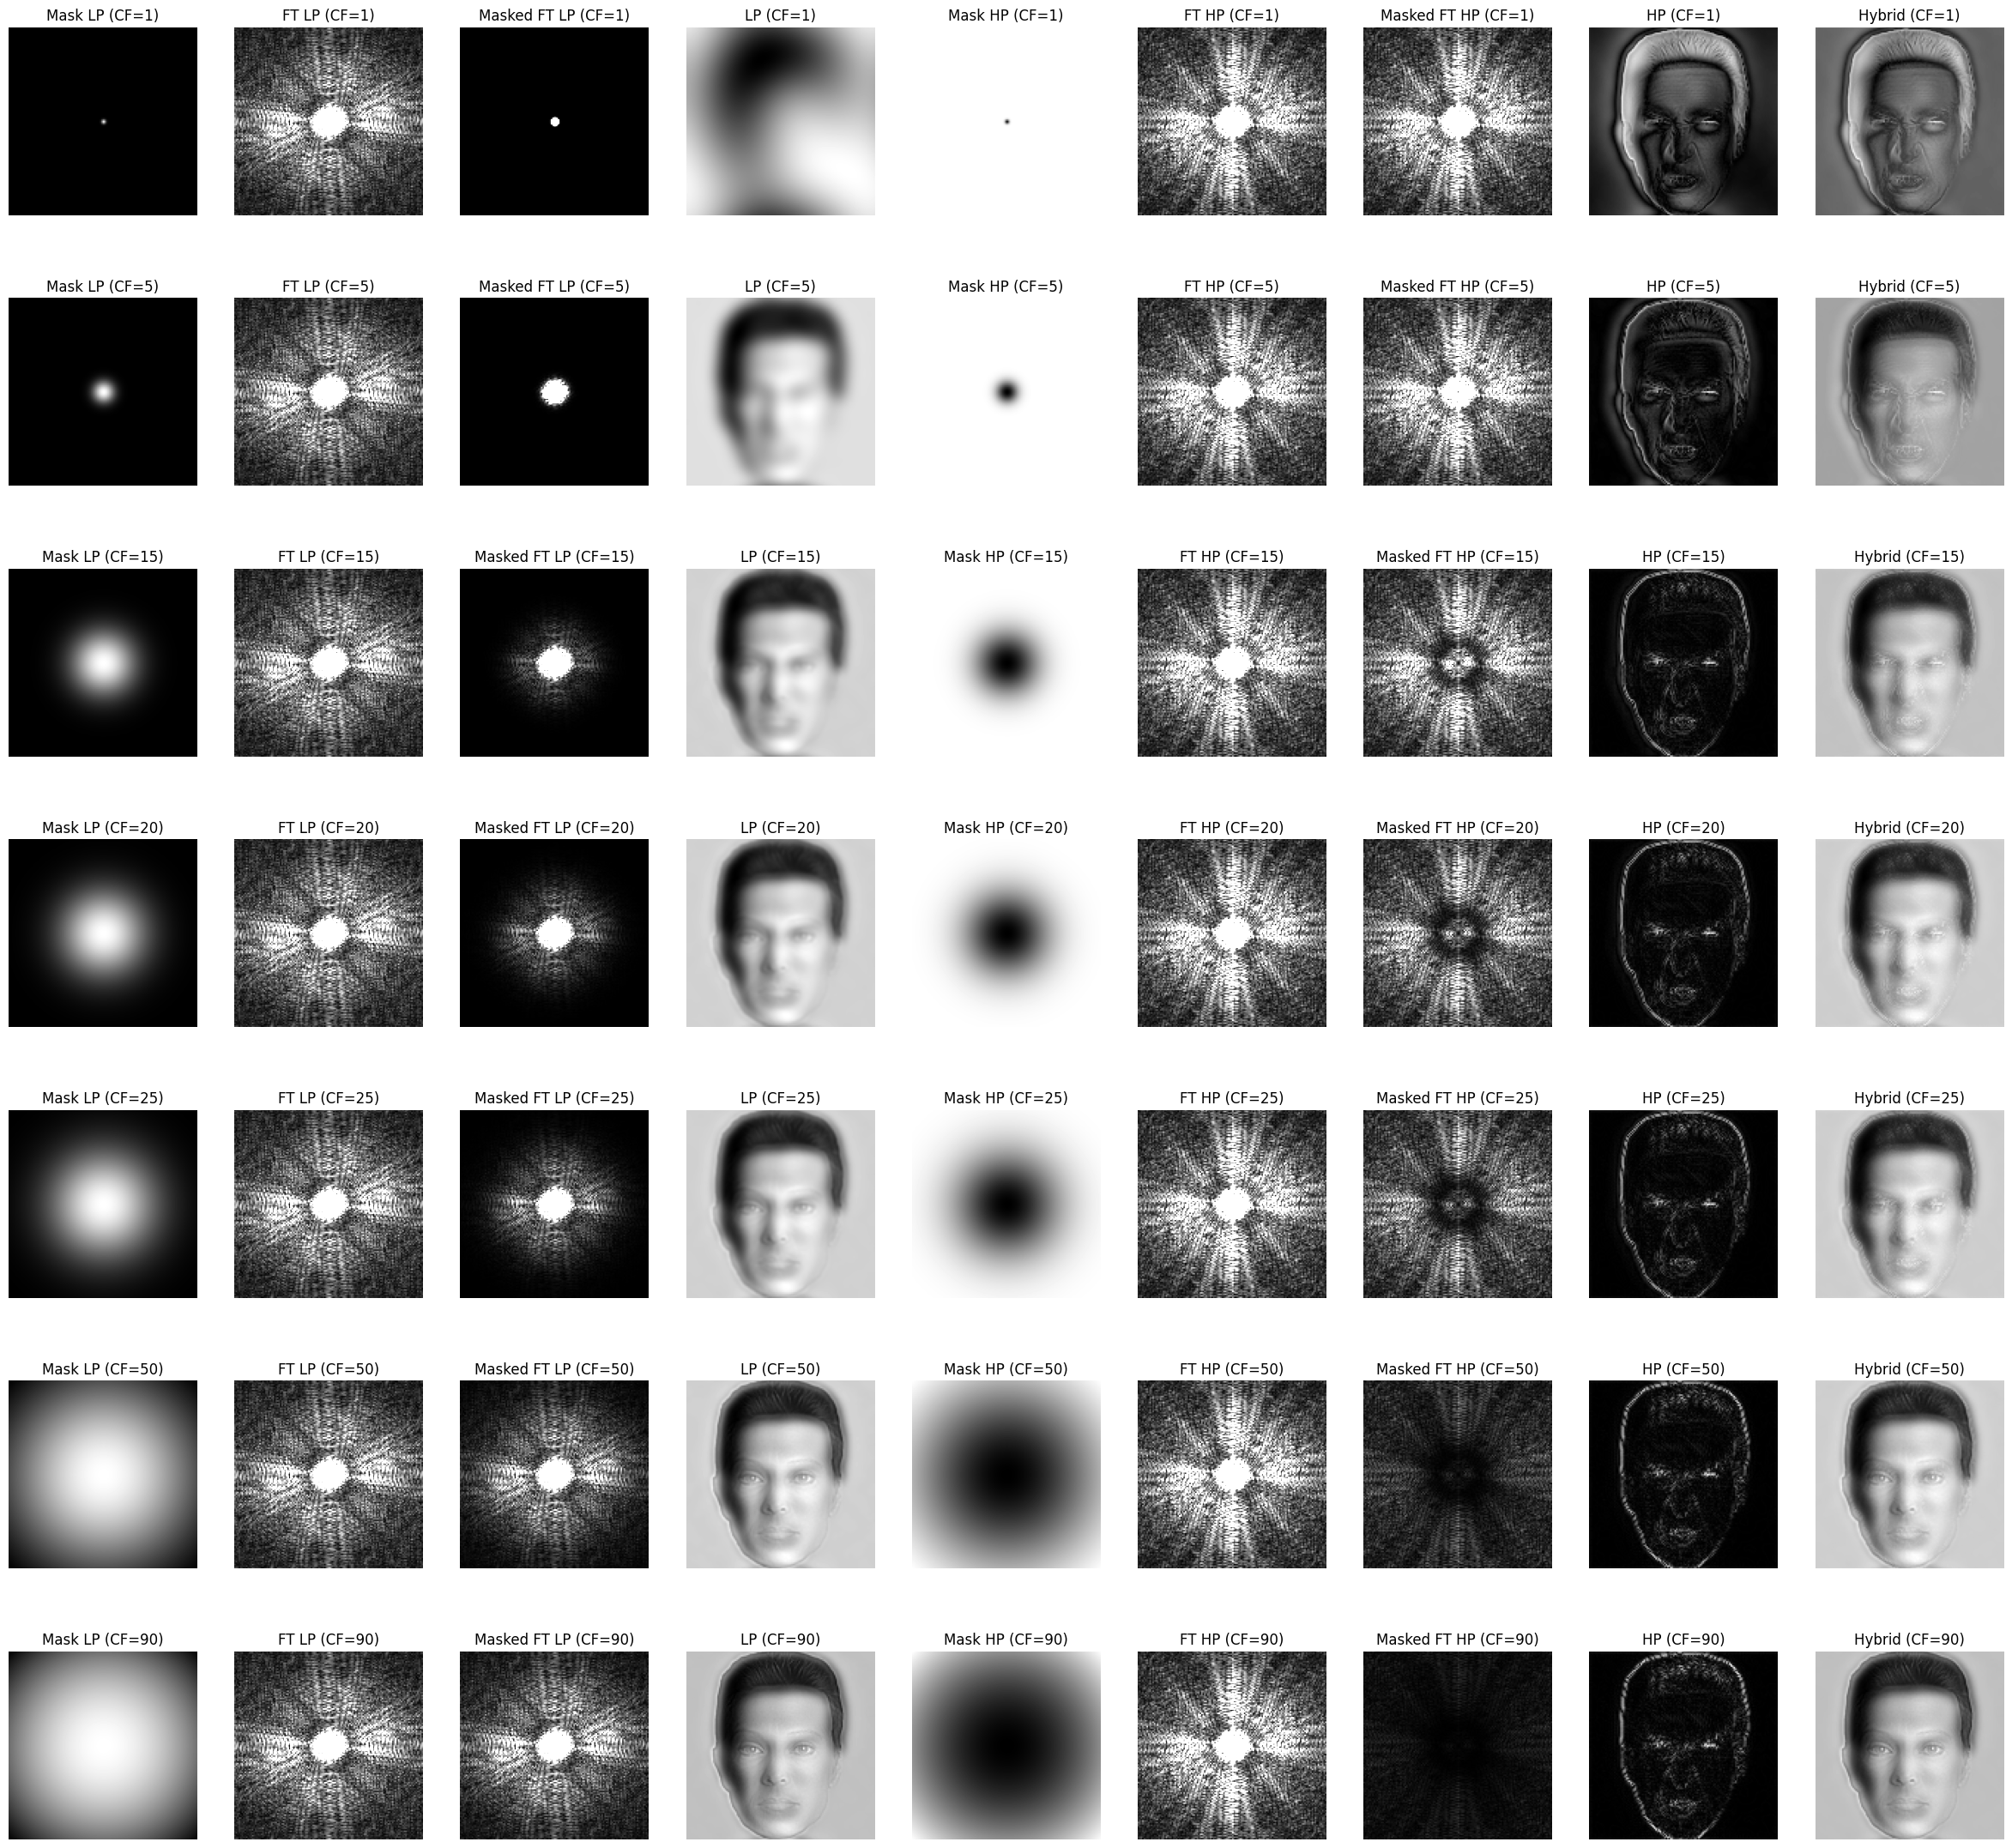

In [7]:
plots = []

for cf in cutoff_frequencies:
    mask_lp, ft_lp, masked_ft_lp, image_lp = apply_low_pass_filter(
        image_set_name, size=size, cf=cf, filter_mode=filter_mode
    )
    mask_hp, ft_hp, masked_ft_hp, image_hp = apply_high_pass_filter(
        image_set_name, size=size, cf=cf, filter_mode=filter_mode
    )
    image_hybrid = create_hybrid_image(image_lp, image_hp)

    plots.extend(
        [
            (mask_lp, f"Mask LP (CF={cf})", False),
            (ft_lp, f"FT LP (CF={cf})", True),
            (masked_ft_lp, f"Masked FT LP (CF={cf})", True),
            (image_lp, f"LP (CF={cf})", False),
            (mask_hp, f"Mask HP (CF={cf})", False),
            (ft_hp, f"FT HP (CF={cf})", True),
            (masked_ft_hp, f"Masked FT HP (CF={cf})", True),
            (image_hp, f"HP (CF={cf})", False),
            (image_hybrid, f"Hybrid (CF={cf})", False),
        ]
    )

plot_figure(
    plots,
    len(cutoff_frequencies),
    9,
    fig_width=30,
    fig_height=len(cutoff_frequencies) * 4,
)

## Create one Hybrid Image

Decide based on the plot above which is the best cutoff frequency for the low-pass filter and the high-pass filter. Then, set best_cf to get the best hybrid image.

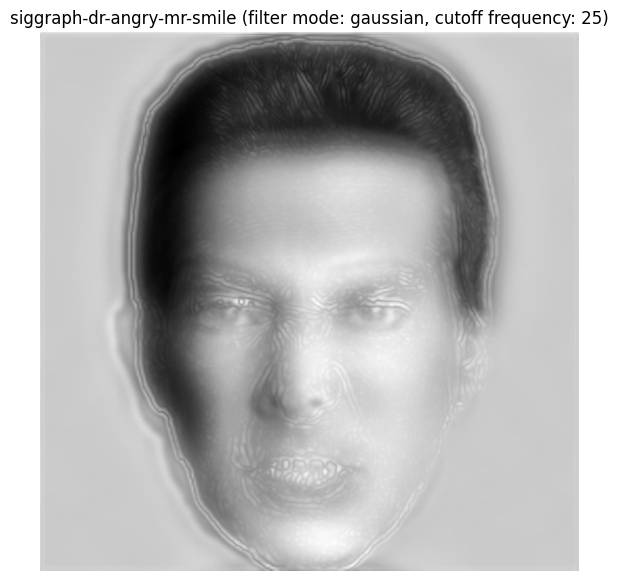

In [8]:
best_cf = 25

size_large = 1024

mask_lp, ft_lp, masked_ft_lp, image_lp = apply_low_pass_filter(
		image_set_name, size=size_large, cf=best_cf, filter_mode=filter_mode
)
mask_hp, ft_hp, masked_ft_hp, image_hp = apply_high_pass_filter(
		image_set_name, size=size_large, cf=best_cf, filter_mode=filter_mode
)
image_hybrid = create_hybrid_image(image_lp, image_hp)

plot_figure(
    [(image_hybrid, f"{image_set_name} (filter mode: {filter_mode}, cutoff frequency: {best_cf})", False)],
    1,
    1,
)